#This model uses LSTM to predict a Daily share price movements based on time series and batches of 60 days

# Read the CSV and Perform Basic Data Cleaning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df_stock1 = pd.read_csv("../static/data/gmg.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df = df_stock2.dropna()
# Drop the last rows to test prediction to actual
df_stock_less1= df_stock2.iloc[:-1,:]
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,RBA,FED,CPI
4419,25/07/2022,19.250000,19.370001,19.090000,19.350000,19.350000,2557809,1.35,1.75,125.0
4420,26/07/2022,19.360001,19.469999,19.180000,19.340000,19.340000,1828309,1.35,1.75,125.0
4421,27/07/2022,19.350000,19.520000,19.225000,19.440001,19.440001,1532053,1.35,2.50,125.0
4422,28/07/2022,19.520000,19.809999,19.315001,19.790001,19.790001,2882320,1.35,2.50,125.0
4423,29/07/2022,20.290001,20.850000,20.200001,20.700001,20.700001,5376051,1.35,2.50,125.0


In [3]:
# Connect to MongoDb
from pymongo import MongoClient
mongoClient = MongoClient()
db = mongoClient.sharesDB

# # Drop all previous records now in MongoDb
# db.gmg.drop()

# # Insert df records in mongodb
# records=df.to_dict('records')
# records
# db.gmg.insert_many(records)

In [4]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.gmg.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("DELETE: "+last_date,last_close)

db.gmg.delete_one(
    {'Date': last_date}
)

DELETE: 02/08/2022 20.43000030517578


In [5]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.gmg.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("NEW LAST VALUE IN MONGODB: "+last_date,last_close)

from datetime import date,datetime
todaydt = date.today()
today=todaydt.strftime('%d-%m-%Y')
from_date = datetime.strptime(last_date, '%d/%m/%Y')
last_date=from_date.strftime('%d-%m-%Y')
print("Previous last date in MongoDb: "+last_date+". Today's date: "+today)

NEW LAST VALUE IN MONGODB: 01/08/2022 20.649999618530273
Previous last date in MongoDb: 01-08-2022. Today's date: 03-08-2022


In [6]:
#Get latest quotes from yahoo finance:
import pandas_datareader.data as web
symbol = 'GMG.AX'
start = from_date # yyyy-mm-dd
end = todaydt  # yyyy-mm-dd
stock_quote = web.DataReader(symbol,data_source='yahoo',start=start, end=end) # dataframe
stock_quote


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-08-01,20.879999,20.530001,20.750000,20.650000,3380282,20.650000
2022-08-02,20.549999,19.980000,20.520000,20.430000,3492361,20.430000
2022-08-03,20.600000,20.190001,20.370001,20.469999,3051566,20.469999


In [7]:
#remove last date already in mongodb
stock_quote=stock_quote.iloc[1:]
stock_quote

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-08-02,20.549999,19.980000,20.520000,20.430000,3492361,20.430000
2022-08-03,20.600000,20.190001,20.370001,20.469999,3051566,20.469999


In [8]:
tot=len(stock_quote)
rba=1.35
fed=2.5
cpi=125
a,b,c=[],[],[]
for i in range(tot):
    a.append(rba)
    b.append(fed)
    c.append(cpi)
# print(a,b,c)
#ADD NEW DATA IN DATAFRAME
stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
stock_quote.reset_index(inplace=True)

stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
stock_quote['Date']=stock_quote['Date'].dt.strftime('%d/%m/%Y')
stock_quote['Date']=stock_quote['Date'].astype(str)
stock_quote

C:\Users\antoi\AppData\Local\Temp/ipykernel_31584/1960956411.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
C:\Users\antoi\AppData\Local\Temp/ipykernel_31584/1960956411.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
C:\Users\antoi\AppData\Local\Temp/ipykernel_31584/1960956411.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

,Date,High,Low,Open,Close,Volume,Adj Close,RBA,FED,CPI
0,02/08/2022,20.549999,19.980000,20.520000,20.430000,3492361,20.430000,1.35,2.5,125
1,03/08/2022,20.600000,20.190001,20.370001,20.469999,3051566,20.469999,1.35,2.5,125


UPDATE MONGO DB

In [9]:
records=stock_quote.to_dict('records')
records

[{'Date': '02/08/2022',
  'High': 20.549999237060547,
  'Low': 19.979999542236328,
  'Open': 20.520000457763672,
  'Close': 20.43000030517578,
  'Volume': 3492361,
  'Adj Close': 20.43000030517578,
  'RBA': 1.35,
  'FED': 2.5,
  'CPI': 125},
 {'Date': '03/08/2022',
  'High': 20.600000381469727,
  'Low': 20.190000534057617,
  'Open': 20.3700008392334,
  'Close': 20.469999313354492,
  'Volume': 3051566,
  'Adj Close': 20.469999313354492,
  'RBA': 1.35,
  'FED': 2.5,
  'CPI': 125}]

In [10]:
#INSERT NEW DATA INTO MONGODB
db.gmg.insert_many(records)

#Check if mongoDb now has latest data
df_mongo = pd.DataFrame(list(db.gmg.find()))

last_val = df_mongo.iloc[-10:].values
print(last_val)

[[ObjectId('62e9ad47170cc681fe87727a') '21/07/2022' 19.280001 19.389999
  18.98 19.15 19.15 3334028 1.35 1.75 125.0]
 [ObjectId('62e9ad47170cc681fe87727b') '22/07/2022' 19.200001 19.41
  19.190001 19.23 19.23 4059016 1.35 1.75 125.0]
 [ObjectId('62e9ad47170cc681fe87727c') '25/07/2022' 19.25 19.370001 19.09
  19.35 19.35 2557809 1.35 1.75 125.0]
 [ObjectId('62e9ad47170cc681fe87727d') '26/07/2022' 19.360001 19.469999
  19.18 19.34 19.34 1828309 1.35 1.75 125.0]
 [ObjectId('62e9ad47170cc681fe87727e') '27/07/2022' 19.35 19.52 19.225
  19.440001 19.440001 1532053 1.35 2.5 125.0]
 [ObjectId('62e9ad47170cc681fe87727f') '28/07/2022' 19.52 19.809999
  19.315001 19.790001 19.790001 2882320 1.35 2.5 125.0]
 [ObjectId('62e9ad4a170cc681fe877281') '29/07/2022' 20.290000915527344
  20.850000381469727 20.200000762939453 20.700000762939453
  20.700000762939453 5376051 1.35 2.5 125.0]
 [ObjectId('62e9ad4a170cc681fe877282') '01/08/2022' 20.75
  20.8799991607666 20.530000686645508 20.649999618530273
  20.

In [11]:
#Save latest to variables
last_val = df_mongo.iloc[-1:].values
last_date = last_val[0][1]
last_close = last_val[0][5]
print(last_date,last_close)

03/08/2022 20.469999313354492


# # Pre-processing : Scale the data using the MinMaxScaler and split train data

In [12]:
df_mongo = pd.DataFrame(list(db.gmg.find()))
# Drop the null columns where all values are null
df_mongo = df_mongo.dropna(axis='columns', how='all')
# Drop the null rows
df_mongo = df_mongo.dropna()
# df_mongo.shape

len_df_mongo=len(df_mongo)
data = df_mongo.filter(["Close"])
dataset=data.values
dataset.shape

(4427, 1)

In [13]:
# data = df.filter(['Close'])
# dataset = data.values
# dataset.shape	

In [14]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
dataset_scaled = scaler.fit_transform(dataset)

# Split into train or test
import math
train_data_len = math.ceil(len(dataset)*.8)
train_data = dataset_scaled[0:train_data_len,:]
train_data.shape


(3542, 1)

In [15]:
X_train = []
y_train = []

for i in range (60, len(train_data)):
    X_train.append(train_data[i-60:i,0]) # contains 60 values
    y_train.append(train_data[i,0])   # contains 61st value
    if i<= 60:
        print(X_train)
        print(y_train) 


[array([0.53145168, 0.52743552, 0.52877425, 0.54751621, 0.54082264,
       0.53680651, 0.53279035, 0.53412914, 0.52743552, 0.51270973,
       0.51137103, 0.50333874, 0.5060162 , 0.50200007, 0.49664524,
       0.50200007, 0.49396781, 0.48995168, 0.50333874, 0.50467753,
       0.51003236, 0.5073549 , 0.50333874, 0.51003236, 0.50869363,
       0.50333874, 0.49262914, 0.49262914, 0.49530651, 0.49129041,
       0.49530651, 0.49664524, 0.49932264, 0.50066137, 0.49798397,
       0.48861298, 0.48727431, 0.48727431, 0.48861298, 0.48727431,
       0.48861298, 0.48727431, 0.48459685, 0.48995168, 0.48191942,
       0.48861298, 0.48727431, 0.48727431, 0.48727431, 0.49798397,
       0.49262914, 0.48459685, 0.49530651, 0.5060162 , 0.50200007,
       0.50467753, 0.51003236, 0.51270973, 0.50467753, 0.5073549 ])]
[0.5100323619667402]


# Prepare train data for LSTM model

In [16]:
# Convert list to numpy array for LSTM model:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(3482, 60)

In [17]:
# LSTM model expects 3D, reshape:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(3482, 60, 1)

# Build the LSTM model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [19]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [20]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

3482/3482 [==============================] - 54s 15ms/step - loss: 0.0011


In [21]:
#Create test data
test_data = dataset_scaled[train_data_len-60:,:]
X_test = []
y_test = dataset[train_data_len:,:]
for i in range(60, len(test_data)):
 X_test.append(test_data[i-60:i,0])

In [22]:
#Covert test data to a numpy array and reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [23]:
#Get predicted prices
predictions_lstm = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_lstm)

In [24]:
#Get the root mean square error (RMSE) 0 being most favourable
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.05309190473632818

C:\Users\antoi\AppData\Local\Temp/ipykernel_31584/4067381219.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


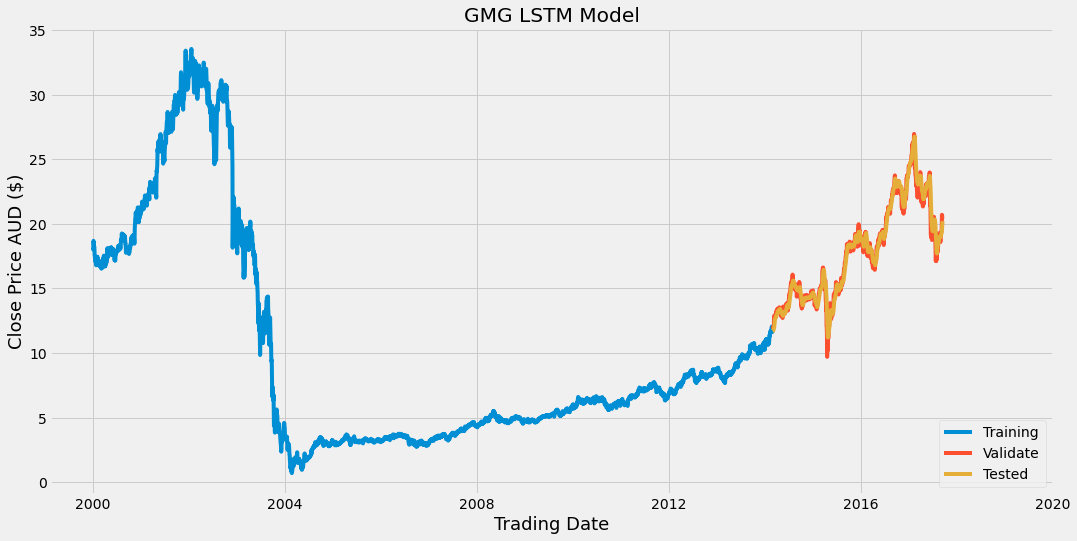

In [25]:
#Plot the data to validate the test data
plt.style.use('fivethirtyeight')
train = data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = data.iloc[train_data_len:] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test

plt.figure(figsize=(16,8))
plt.title('GMG LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training','Validate','Tested'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/gmg_graph.png')
plt.show()

# Test data Predictions on the Model

In [26]:
valid['Difference']= valid['Close']-valid['Predictions']
valid.head

C:\Users\antoi\AppData\Local\Temp/ipykernel_31584/3403988079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference']= valid['Close']-valid['Predictions']


<bound method NDFrame.head of           Close  Predictions  Difference
3542  11.860000    11.677094    0.182906
3543  11.910000    11.686198    0.223802
3544  12.030000    11.713263    0.316737
3545  12.000000    11.762479    0.237521
3546  12.020000    11.809161    0.210839
...         ...          ...         ...
4422  19.790001    19.366961    0.423040
4423  20.700001    19.484758    1.215242
4424  20.650000    19.748180    0.901819
4425  20.430000    20.016134    0.413866
4426  20.469999    20.210196    0.259804

[885 rows x 3 columns]>

In [27]:
# Use last 60 days price on model to predict next days price
import pandas as pd

df_mongo = pd.DataFrame(list(db.gmg.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty.shape

(60, 1)

In [28]:
last_60_days_scaled = scaler.transform(last_sixty)
X_tell = []
X_tell.append(last_60_days_scaled)
X_tell =np.array(X_tell)
X_tell =np.reshape(X_tell, (X_tell.shape[0], X_tell.shape[1],1))
X_tell.shape

(1, 60, 1)

In [29]:
pred_price = model.predict(X_tell)
pred_price = scaler.inverse_transform(pred_price)
pred_price = int(pred_price)
print(f'{last_date} Last close ${last_close} Predicted next day share price ${pred_price}')

03/08/2022 Last close $20.469999313354492 Predicted next day share price $20


# Save the Model

In [30]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
filepath = '../static/gmg_model.sav'
model.save(filepath, save_format="h5")

#Save last 60 days to a list gmg_sixty and load df

#PREDICT USING LOADED MODEL

In [31]:
from keras.models import load_model
model_in = load_model('../static/gmg_model.sav')

In [32]:
# query the gmg collection and load into dataframe

df_mongo = pd.DataFrame(list(db.gmg.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty

array([[19.        ],
       [18.860001  ],
       [19.190001  ],
       [19.469999  ],
       [18.75      ],
       [18.719999  ],
       [18.67      ],
       [19.030001  ],
       [19.07      ],
       [19.110001  ],
       [19.43      ],
       [19.620001  ],
       [19.6       ],
       [20.040001  ],
       [20.219999  ],
       [20.23      ],
       [19.91      ],
       [20.08      ],
       [20.        ],
       [19.4       ],
       [19.360001  ],
       [18.879999  ],
       [18.58      ],
       [17.209999  ],
       [17.049999  ],
       [17.325001  ],
       [16.799999  ],
       [17.129999  ],
       [17.370001  ],
       [17.219999  ],
       [17.65      ],
       [18.184999  ],
       [18.68      ],
       [18.74      ],
       [18.129999  ],
       [17.84      ],
       [18.139999  ],
       [18.540001  ],
       [18.43      ],
       [18.530001  ],
       [19.030001  ],
       [18.75      ],
       [18.549999  ],
       [18.52      ],
       [18.85      ],
       [18

#Create a function to loop through the days input

In [33]:
from keras.models import load_model
model_in = load_model('../static/gmg_model.sav')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

price_list=[]

#Function to predict future days predicted price, in loop
input = 180 #days
if input == "":
    input = 180
else:
   input = int(input)

def predict_gmg(last_sixty,model_in,input):
    for i in range(1, input):

        #Takes df and converts to model's predict shape
        last_sixty_scaled = scaler.fit_transform(last_sixty)
        new_X_tell = []
        new_X_tell.append(last_sixty_scaled)
        new_X_tell =np.array(new_X_tell)
        new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
        
        model_in_pd_scale = model_in.predict(new_X_tell)
        model_in_price = scaler.inverse_transform(model_in_pd_scale) # New price predicted

        last_sixty_less_one = np.delete(last_sixty, 0, 0)
        last_sixty = np.append(last_sixty_less_one, model_in_price,axis = 0) # Update last 60
        print(i)
        print("Day finished! Price: ")
        price_float = float(model_in_price)
        price = round(price_float, 2)
        price_list.append(price)
    else:
        print("Could not predict further!")
        print(input)
    # print(price_list)
    return price_list

price_pred = predict_gmg(last_sixty,model_in,input)
price_pred

1
Day finished! Price: 
2
Day finished! Price: 
3
Day finished! Price: 
4
Day finished! Price: 
5
Day finished! Price: 
6
Day finished! Price: 
7
Day finished! Price: 
8
Day finished! Price: 
9
Day finished! Price: 
10
Day finished! Price: 
11
Day finished! Price: 
12
Day finished! Price: 
13
Day finished! Price: 
14
Day finished! Price: 
15
Day finished! Price: 
16
Day finished! Price: 
17
Day finished! Price: 
18
Day finished! Price: 
19
Day finished! Price: 
20
Day finished! Price: 
21
Day finished! Price: 
22
Day finished! Price: 
23
Day finished! Price: 
24
Day finished! Price: 
25
Day finished! Price: 
26
Day finished! Price: 
27
Day finished! Price: 
28
Day finished! Price: 
29
Day finished! Price: 
30
Day finished! Price: 
31
Day finished! Price: 
32
Day finished! Price: 
33
Day finished! Price: 
34
Day finished! Price: 
35
Day finished! Price: 
36
Day finished! Price: 
37
Day finished! Price: 
38
Day finished! Price: 
39
Day finished! Price: 
40
Day finished! Price: 
41
Day fi

[19.91,
 19.96,
 19.98,
 19.99,
 19.99,
 20.0,
 20.0,
 20.0,
 20.0,
 20.0,
 20.0,
 20.01,
 20.01,
 20.02,
 20.02,
 20.02,
 20.03,
 20.03,
 20.04,
 20.04,
 20.05,
 20.05,
 20.06,
 20.07,
 20.07,
 20.08,
 20.08,
 20.09,
 20.09,
 20.09,
 20.1,
 20.1,
 20.11,
 20.11,
 20.11,
 20.12,
 20.12,
 20.12,
 20.13,
 20.13,
 20.13,
 20.14,
 20.14,
 20.14,
 20.15,
 20.15,
 20.15,
 20.16,
 20.16,
 20.16,
 20.16,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,
 20.17,


In [34]:
import pandas as pd
from datetime import date,datetime,timedelta
today1 = date.today()
count=[]
dates=[]
dow=[]
row=0
for x in range(1,293,1): 
  d=today1+timedelta(days=x)
  a=d.strftime("%A")
  if a != "Saturday" and a != "Sunday":
     dates.append(d.strftime('%d-%m-%Y'))
     dow.append(a)
     row=row+1
     count.append(row)

data = {'Count': count,
        'Date': dates,
        'DOW': dow
        }
dates_df = pd.DataFrame(data)
print (dates_df.tail)

<bound method NDFrame.tail of      Count        Date        DOW
0        1  04-08-2022   Thursday
1        2  05-08-2022     Friday
2        3  08-08-2022     Monday
3        4  09-08-2022    Tuesday
4        5  10-08-2022  Wednesday
..     ...         ...        ...
203    204  16-05-2023    Tuesday
204    205  17-05-2023  Wednesday
205    206  18-05-2023   Thursday
206    207  19-05-2023     Friday
207    208  22-05-2023     Monday

[208 rows x 3 columns]>


In [35]:
today1= datetime.today()
today3=today1.strftime('%d-%m-%Y')
today2=datetime.strptime(today3, '%d-%m-%Y')


#Check if mongoDb now has latest data
dates_df = pd.DataFrame(list(db.dates.find()))
dates_val = dates_df.iloc[0].values
last_date1=dates_val[2]
last_date2 = datetime.strptime(last_date1, '%d-%m-%Y')
last_date3=from_date.strftime('%d-%m-%Y')

today_str=today1.strftime('%d-%m-%Y')

print(last_date2,today2)
diff=last_date2-today1

if diff is None:
    print("huh")
else:
    print(diff)

    # Drop all previous records now in MongoDb
    db.dates.drop()

    records=dates_df.to_dict('records')

    #INSERT NEW DATA INTO MONGODB
    db.dates.insert_many(records)

    #Check if mongoDb now has latest data
    dates_df = pd.DataFrame(list(db.dates.find()))
    dates_val = dates_df.iloc[-10:].values
    print(dates_val)


2022-07-28 00:00:00 2022-08-03 00:00:00
-7 days, 3:51:50.538774
[[ObjectId('62e112b2fb7cbba54bf62c9f') 199 '02-05-2023' 'Tuesday']
 [ObjectId('62e112b2fb7cbba54bf62ca0') 200 '03-05-2023' 'Wednesday']
 [ObjectId('62e112b2fb7cbba54bf62ca1') 201 '04-05-2023' 'Thursday']
 [ObjectId('62e112b2fb7cbba54bf62ca2') 202 '05-05-2023' 'Friday']
 [ObjectId('62e112b2fb7cbba54bf62ca3') 203 '08-05-2023' 'Monday']
 [ObjectId('62e112b2fb7cbba54bf62ca4') 204 '09-05-2023' 'Tuesday']
 [ObjectId('62e112b2fb7cbba54bf62ca5') 205 '10-05-2023' 'Wednesday']
 [ObjectId('62e112b2fb7cbba54bf62ca6') 206 '11-05-2023' 'Thursday']
 [ObjectId('62e112b2fb7cbba54bf62ca7') 207 '12-05-2023' 'Friday']
 [ObjectId('62e112b2fb7cbba54bf62ca8') 208 '15-05-2023' 'Monday']]


In [36]:
dates_df = pd.DataFrame(list(db.dates.find()))
dates_val = dates_df.iloc[0:,1:]
# dates_df['Count'].dtype
# dates_df_iloc = dates_df.iloc[0:180,1:]
dates_val

,Count,Date,DOW
0,1,28-07-2022,Thursday
1,2,29-07-2022,Friday
2,3,01-08-2022,Monday
3,4,02-08-2022,Tuesday
4,5,03-08-2022,Wednesday
...,...,...,...
203,204,09-05-2023,Tuesday
204,205,10-05-2023,Wednesday
205,206,11-05-2023,Thursday
206,207,12-05-2023,Friday


In [37]:
# import pandas as pd
# dates_df = pd.read_csv("../static/data/dates.csv")
# dates_df['Count'] = dates_df['Count'].fillna(0).astype(int)
# dates_df

C:\Users\antoi\AppData\Local\Temp/ipykernel_31584/3701609558.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_df_iloc['Price'] = price_list


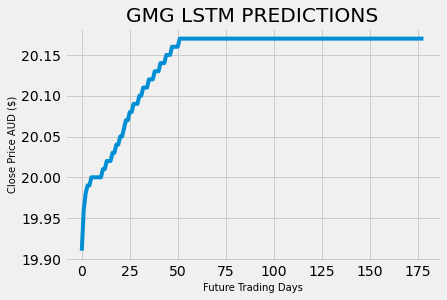

In [38]:
# DRAW THE PREDICTION
#Append the input amount of trading days to dates dictionary
dates_df_iloc = dates_df.iloc[0:(input-1)]
dates_df_iloc['Price'] = price_list
plt.plot(dates_df_iloc['Price'])
plt.title('GMG LSTM PREDICTIONS')
plt.xlabel('Future Trading Days', fontsize=10)
plt.ylabel('Close Price AUD ($)',fontsize=10)
plt.savefig('../static/data/images/gmg_pred.png', bbox_inches="tight")
plt.show()

In [39]:
#Append the input amount of trading days to dates dictionary
my_dict = dates_df_iloc.to_dict(orient='records')
print(my_dict[0])
price_dict = [dict(zip(['Price'],[x])) for x in price_list]
# print(price_dict[0])

{'_id': ObjectId('62e112b2fb7cbba54bf62bd9'), 'Count': 1, 'Date': '28-07-2022', 'DOW': 'Thursday', 'Price': 19.91}


In [40]:
len_df_mongo = len(df_mongo) # length of the original dataframe
col_name = ['Close']
df_filtered = df.filter(col_name)
df_filtered_len = len(df_filtered.index)
df_filtered_len
len_pred_df = df_filtered_len+input # length of the original dataframe plus the users new inputs

new_data =df_filtered.append(pd.DataFrame(price_list,columns=col_name),ignore_index=True)
new_data.tail(10)
print(train_data_len,len_df_mongo,len_pred_df)


3542 4427 4604


C:\Users\antoi\AppData\Local\Temp/ipykernel_31584/3489515865.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


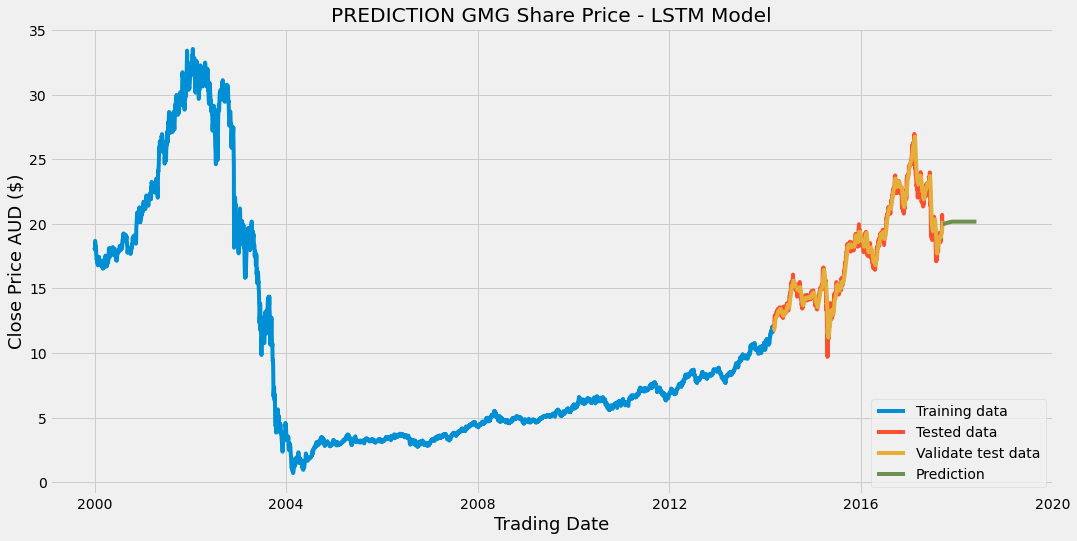

In [41]:
#Plot the data to validate the test data

plt.style.use('fivethirtyeight')
train = new_data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = new_data.iloc[train_data_len:len_df_mongo] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test
predict = new_data.iloc[len_df_mongo:len_pred_df] # user prediction data from loop

plt.figure(figsize=(16,8))
plt.title('PREDICTION GMG Share Price - LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.plot(predict['Close'])
plt.legend(['Training data','Tested data','Validate test data','Prediction'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/gmg_predict_graph.png')
plt.show()

#Save predicted price to MongoDB

In [42]:
# Query all
name = 'GMG'
companys = db.companys.find({'name': name})
# Iterate through each company in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62e9ad88170cc681fe877284'), 'model': 'LSTM', 'name': 'GMG', 'date': '02/08/2022', 'predicted': 18, 'actual': 20.43, 'difference': -2.43, 'rmse': 0.77751}
{'_id': ObjectId('62e9c67c308fc9501734fafc'), 'model': 'RFR', 'name': 'GMG', 'date': '02/08/2022', 'predicted': 18, 'actual': 20, 'difference': -1.8275, 'accuracy': 95.75}


In [43]:
# Delete a document from a collection
db.companys.delete_one(
    {'model': 'LSTM','name': name}
)

# query the companys collection
companys = db.companys.find({'name': name})
# see change in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62e9c67c308fc9501734fafc'), 'model': 'RFR', 'name': 'GMG', 'date': '02/08/2022', 'predicted': 18, 'actual': 20, 'difference': -1.8275, 'accuracy': 95.75}


In [44]:
# Set keys and values of company
name = 'GMG'
# Set keys and values of company
last_close=round(float(last_close),2)
difference = pred_price-last_close
print(f'date {last_date},predicted ${pred_price}, actual ${last_close}, difference {difference}, rmse {round(rmse,5)}')

date 03/08/2022,predicted $20, actual $20.47, difference -0.46999999999999886, rmse 0.05309


In [45]:
# Insert a document into the 'companys' collection
db.companys.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': pred_price,
      'actual': last_close,
      'difference': round(difference,4),
      'rmse': round(rmse,5)        
    }
)

# query the classroom collection
companys = db.companys.find({'name': name})

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62e9c67c308fc9501734fafc'), 'model': 'RFR', 'name': 'GMG', 'date': '02/08/2022', 'predicted': 18, 'actual': 20, 'difference': -1.8275, 'accuracy': 95.75}
{'_id': ObjectId('62ea490ac12cdc87826b5449'), 'model': 'LSTM', 'name': 'GMG', 'date': '03/08/2022', 'predicted': 20, 'actual': 20.47, 'difference': -0.47, 'rmse': 0.05309}


In [46]:
# query all the classroom collection
companys = db.companys.find()

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62cfb5f0a3e49b5607e1001b'), 'model': 'RFR', 'name': 'nhc', 'date': '14/07/2022', 'predicted': 3, 'actual': 4, 'differece': -0.4134955929131614, 'accuracy': 95.31}
{'_id': ObjectId('62e236dd0512e77444960bd6'), 'model': 'RFR', 'name': 'NIC', 'date': '28/07/2022', 'predicted': 0.92, 'actual': 1.09, 'differece': -0.170910457265107, 'accuracy': 91.93}
{'_id': ObjectId('62e47c25ddd32d7e027d5c65'), 'model': 'LSTM', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 19, 'actual': 18.34, 'differece': 0.6600000000000001, 'rmse': 0.73826}
{'_id': ObjectId('62e481c2f248345c96c9494d'), 'model': 'RFR', 'name': 'fmg', 'date': '29/07/2022', 'predicted': 12, 'actual': 18, 'differece': -5.209653763866996, 'accuracy': 91.31}
{'_id': ObjectId('62e50595000bd2fa71a88d82'), 'model': 'RFR', 'name': 'wes', 'date': '29/07/2022', 'predicted': 44, 'actual': 38, 'difference': 6.9125, 'accuracy': 97.16}
{'_id': ObjectId('62e63809b66c4b7fa3db1a22'), 'model': 'RFR', 'name': 'anz', 'date': '29/07/2022